# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL.Image
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import layers
from zipfile import ZipFile

# Load and Prepare Data

In [ ]:
# loading the zip and creating a zip object
with ZipFile("/content/drive/MyDrive/birds23wi.zip", 'r') as zObject:
	zObject.extractall(
		path="../input/birds23wi/")


In [ ]:
train_folder = os.path.join('..', 'input', 'birds23wi', 'birds', 'train')
# /content/drive/MyDrive/birds23wi.zip
file_count = []

# get number of images in each folder (images per class)
for fld in os.listdir(train_folder):
    crt = os.path.join(train_folder, fld)
    
    image_count = len(os.listdir(crt))
    
    file_count.append(image_count)
    
    print(f'{crt} contains {image_count} images')

../input/birds23wi/birds/train/84 contains 36 images
../input/birds23wi/birds/train/216 contains 100 images
../input/birds23wi/birds/train/525 contains 97 images
../input/birds23wi/birds/train/373 contains 31 images
../input/birds23wi/birds/train/506 contains 81 images
../input/birds23wi/birds/train/406 contains 37 images
../input/birds23wi/birds/train/333 contains 28 images
../input/birds23wi/birds/train/524 contains 83 images
../input/birds23wi/birds/train/131 contains 65 images
../input/birds23wi/birds/train/438 contains 71 images
../input/birds23wi/birds/train/82 contains 44 images
../input/birds23wi/birds/train/325 contains 71 images
../input/birds23wi/birds/train/466 contains 41 images
../input/birds23wi/birds/train/181 contains 43 images
../input/birds23wi/birds/train/137 contains 87 images
../input/birds23wi/birds/train/540 contains 87 images
../input/birds23wi/birds/train/99 contains 56 images
../input/birds23wi/birds/train/402 contains 49 images
../input/birds23wi/birds/train

In [ ]:
# Gonna downsample, try to replace with image augmentation later?

In [ ]:
# Checking image sizes for processing
os.listdir(os.path.join(train_folder, '35'))[:10]

['04c2f4a2548448aa9f4a83732583c610.jpg',
 '0688601e1b1848c3b1750326bf663afe.jpg',
 '8236ecb04fa14b92881675c475d5ada2.jpg',
 '8b624f92cb1d4db9aaef9edcdf776217.jpg',
 '08448b0a3529435ea3e2ab3fc5661d21.jpg',
 'cd2917aa4fd141c88ce3c28f105827b6.jpg',
 '887aea7565b041758d25f4484e5ce869.jpg',
 '1dc4059b92604ead9dd4c02a8803f464.jpg',
 '48b640b788b04111949bd5a5e43694e7.jpg',
 '04afef67aabe406cbab23f8229deeded.jpg']

In [ ]:
data_dir = pathlib.Path(train_folder)
testlist = list(data_dir.glob('35/*'))
PIL.Image.open(str(testlist[0])).size

(1024, 768)

In [ ]:
data_dir = pathlib.Path(train_folder)
testlist = list(data_dir.glob('105/*'))
PIL.Image.open(str(testlist[0])).size

(1024, 683)

In [ ]:
# Crop/resize images into same size for model, I think
# Since object is centered, can crop to square and resize to same dimension?

"""
def crop_to_square(im):
    w, h = im.size
    side = min(w, h)
    # center
    left = (w - side) / 2
    right = (w + side) / 2
    top = (h - side) / 2
    low = (h + side) / 2
    return im.crop((left, top, right, low)).convert('RGB')
"""

"\ndef crop_to_square(im):\n    w, h = im.size\n    side = min(w, h)\n    # center\n    left = (w - side) / 2\n    right = (w + side) / 2\n    top = (h - side) / 2\n    low = (h + side) / 2\n    return im.crop((left, top, right, low)).convert('RGB')\n"

actually nvm cropping ^ think better to resize

In [ ]:
out_folder = os.path.join('..', 'output', 'birds23wi', 'processed')
new_size = (800, 800)

def process_train(train, no_of_imgs):
    # iterate through all folders
    for fld in os.listdir(train):
        out = os.path.join(out_folder, fld)
        # create output folder (after delete if it already exists)
        if os.path.exists(out):
            shutil.rmtree(out)
        os.makedirs(out)
        
        fld_path = pathlib.Path(os.path.join(train, fld))
        num_images = 0
        for file in list(fld_path.glob('*')):
            with PIL.Image.open(file) as im:
                im1 = im.resize(new_size)
                rgb_im = im1.convert('RGB')
                rgb_im.save(os.path.join(out, str(num_images) + '.jpg'))
                #im.close()
                
            num_images = num_images + 1
            if (num_images > no_of_imgs):
                break

In [ ]:
# downsample size
im_per_class = min(file_count)

# process input images 
process_train(train_folder, im_per_class)

# Keras Preprocessing

In [ ]:
width = new_size[0]
height = new_size[1]
batch_size = 32
data_dir = pathlib.Path(out_folder)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    label_mode='categorical', # for one-hot encoding
    image_size=(height, width),
    batch_size=batch_size
    seed=67,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    image_size=(height, width),
    batch_size=batch_size
    seed=67,
)

Found 6104 files belonging to 555 classes.
Using 4884 files for training.
Found 6104 files belonging to 555 classes.
Using 1220 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', '228', '22

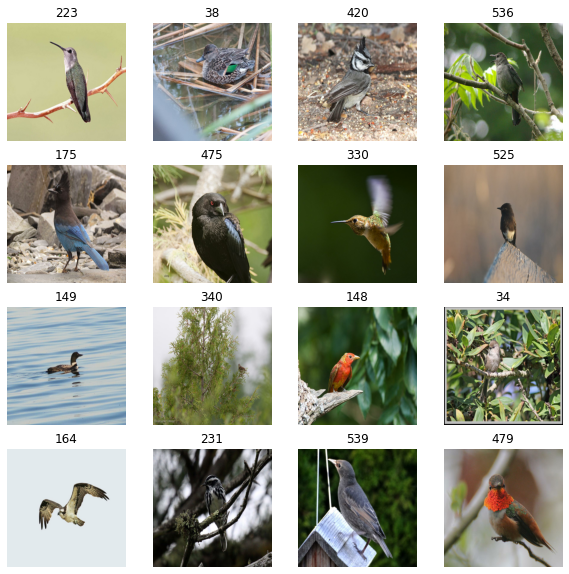

In [ ]:
# just checking how my images look
plt.figure(figsize=(10, 10))

i = 1

for images, labels in train_ds.take(1):
    for (image, label) in zip(images, labels): 
        ax = plt.subplot(4, 4, i)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(label, axis=0)])
        plt.axis("off")
        i = i + 1
        if i == 17:
            break
plt.show()

In [ ]:
# use keras functionality for adding a rescaling layer
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# rescale training and validation sets
# FIX THIS
norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
image_batch, labels_batch = next(iter(norm_train_ds))

# get one image
first_image = image_batch[0]

# confirm pixel values are now in the [0,1] range
print(np.min(first_image), np.max(first_image))

0.0 0.90196085


# Model